In [1]:
import pkg_resources
import darkmode_orange
try:
    pkg_resources.require(['eth-ape','ape-alchemy','ape-etherscan','mplfinance', 'pandas', 'numpy', 'python-dotenv'])
    print('All packages installed')
except:
    !pip3 install eth-ape ape-alchemy ape-etherscan mplfinance pandas numpy python-dotenv

All packages installed


In [2]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import typing as tp
import os
from ape import accounts, chain, Contract, networks

/Users/mihai/.pyenv/versions/3.10.10/envs/ape-stuff/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# manually input your keys like this
# %env WEB3_ALCHEMY_API_KEY = xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
# %env ETHERSCAN_API = xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

# or load from a separate ".env" file, which is more secure!
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
context = networks.parse_network_choice(f"ethereum:mainnet:https://mainnet.infura.io/v3/{os.getenv('INFURA_API_KEY')}")
context.__enter__()
print(f"ape version: {pkg_resources.get_distribution('eth-ape').version}")
print(f"provider.config of type={type(context.provider.config)}")
for k,v in context.provider.config.Config.__dict__.items():
    if not k.startswith('__'):
        print(f" {k} = {v}")


INFO: Connecting to existing Geth node at  https://mainnet.infura.io/v3/0adcd5893aa345109328472d2ddd0426.
ape version: 0.6.8
provider.config of type=<class 'ape_geth.provider.GethConfig'>
 extra = allow


In [5]:
# list plugins and available networks
for plugin_name, ecosystem_class in context.plugin_manager.providers:
    print(f"plugin_name={plugin_name}, ecosystem_class={ecosystem_class}")

plugin_name=test, ecosystem_class=('ethereum', 'local', <class 'ape_test.provider.LocalProvider'>)
plugin_name=alchemy, ecosystem_class=('ethereum', 'mainnet', <class 'ape_alchemy.provider.Alchemy'>)
plugin_name=alchemy, ecosystem_class=('ethereum', 'goerli', <class 'ape_alchemy.provider.Alchemy'>)
plugin_name=alchemy, ecosystem_class=('ethereum', 'sepolia', <class 'ape_alchemy.provider.Alchemy'>)
plugin_name=alchemy, ecosystem_class=('arbitrum', 'mainnet', <class 'ape_alchemy.provider.Alchemy'>)
plugin_name=alchemy, ecosystem_class=('arbitrum', 'goerli', <class 'ape_alchemy.provider.Alchemy'>)
plugin_name=alchemy, ecosystem_class=('optimism', 'mainnet', <class 'ape_alchemy.provider.Alchemy'>)
plugin_name=alchemy, ecosystem_class=('optimism', 'goerli', <class 'ape_alchemy.provider.Alchemy'>)
plugin_name=alchemy, ecosystem_class=('polygon', 'mainnet', <class 'ape_alchemy.provider.Alchemy'>)
plugin_name=alchemy, ecosystem_class=('polygon', 'mumbai', <class 'ape_alchemy.provider.Alchemy'>

In [6]:
# get an account that you can use
dev = accounts.test_accounts[0]
print(f"{dev.balance=}")

dev.balance=0


In [7]:
current_block = chain.blocks[-1].number
print(f"{current_block=}")

current_block=17070864


In [8]:
# determine starting block for the query
seconds_in_day = 86400
seconds_in_block = 12
last_number_of_days = 365
dblocks = int(seconds_in_day*last_number_of_days/seconds_in_block)
start_block = current_block - dblocks
print(f"starting block is {start_block:,.0f} for {last_number_of_days} day lookback")

starting block is 14,442,864 for 365 day lookback


In [9]:
# set up contracts, ABIs come from Etherscan
curve_steth = Contract("0xDC24316b9AE028F1497c275EB9192a3Ea0f67022")
steth = Contract("0xae7ab96520DE3A18E5e111B5EaAb095312D7fE84")
print(f"balance of curve_steth is {steth.balanceOf(curve_steth)/1e18:,.0f} stETH")

balance of curve_steth is 392,320 stETH


In [10]:
# identify the event we want to query
display(curve_steth.TokenExchange)
display(type(curve_steth.TokenExchange))

TokenExchange(address indexed buyer, int128 sold_id, uint256 tokens_sold, int128 bought_id, uint256 tokens_bought)

ape.contracts.base.ContractEvent

In [11]:
# query it
%time query_swaps_recent = curve_steth.TokenExchange.query("*", start_block=current_block-3000) # last 10 hr
query_swaps_recent.head(5) # it's a pandas dataframe 🙌

INFO: Cache database has not been initialized
CPU times: user 46.3 ms, sys: 4.22 ms, total: 50.5 ms
Wall time: 314 ms


,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index
0,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xab1C17100D9083f45Db1eC9223C755470...,0x608c30f20a0c11ad2308cd97628c51cf5441e171f269...,17067867,0xca08382609d8234c1017f49a29c212b983e27b7e5ea4...,222,44
1,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xc4805F44D9086E14216C3360aE89dA9DC...,0xd8731f184a054f706456e7352f36981119ee87ec0708...,17068178,0xa68035f03b9b7105711722d2830324c755c05c19476a...,265,142
2,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x6751Bbbe6c338c1400490b776967CA826...,0xfee0b6f1fe89a5bba57546ad96f34582ad3226cd0ad4...,17068193,0x9a19204692739cf8af0f54a5753f80e347c8cc505168...,161,70
3,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x6751Bbbe6c338c1400490b776967CA826...,0x48a1317067417e49fb8c44f18c200cf3818bdf85ed2e...,17068204,0xb081bfcf432a62720bd6ded493b9f380e875198d250e...,115,56
4,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x22F9dCF4647084d6C31b2765F6910cd85...,0x2b3985f91ee3b0e7edda5729aad842d05544c9cbb048...,17068261,0x81fe5e77afabcc69c12c4191ee59b4fe740c9485f88e...,425,250


In [12]:
# the event arguments field is a dict of the event arguments
display(query_swaps_recent["event_arguments"][0])

{'buyer': '0xab1C17100D9083f45Db1eC9223C7554707dd01bE',
 'sold_id': 1,
 'tokens_sold': 50000000000000000,
 'bought_id': 0,
 'tokens_bought': 49958239091748517}

In [13]:
# ok great. let's look a bit further into the past to start_block from above. see how long it takes
%time query_swaps_original = curve_steth.TokenExchange.query("*", start_block=start_block)
query_swaps_original.head(5)

CPU times: user 8.15 s, sys: 622 ms, total: 8.77 s
Wall time: 8.47 s


,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index
0,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xCCF903600486110373734FF0D1aff00aE...,0x2eec7d521e8d30230026474c6f3bdec71b0db772968f...,14443006,0x626961f3b0783e85c5b5ef89416837019419eca40ea4...,535,396
1,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x22F9dCF4647084d6C31b2765F6910cd85...,0xefa2004889c6b115af4a4b5a956fa934567a877681be...,14443113,0x78a56fe79984b2a50c98da9f2bb64c9f21e0e9fcd213...,148,104
2,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xa10FcA31A2Cb432C9Ac976779DC947CfD...,0xc531cf033a740fb7c93f610f036a36bd31b4383c56b9...,14443210,0x59fbe1f9a7fb4b38b58e7ce7c3b347c18af002025445...,10,0
3,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xDEF171Fe48CF0115B1d80b88dc8eAB591...,0xcc50b92119fb996f7e82e77b1a37c060109089df294b...,14443215,0x83db11d73db1a2c52a50914b8193bc2e11666a70327d...,183,126
4,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xfA9a30350048B2BF66865ee20363067c6...,0xe8d01bb953b2161ece86d5104709b6de0e38a562f9ed...,14443228,0xcd13d2ba745ff59eae3ca9a82bcc9adaf17cf324144a...,700,159


In [14]:
query_swaps = query_swaps_original.copy()
query_swaps["tokens_sold"] = query_swaps["event_arguments"].apply(lambda x: x["tokens_sold"])
query_swaps = query_swaps.loc[query_swaps['tokens_sold'] > 0,:]
print(f"query_swaps shrunk from {len(query_swaps_original)} to {len(query_swaps)} rows by removing {len(query_swaps_original)-len(query_swaps)} rows with tokens_sold=0")

query_swaps shrunk from 68053 to 68049 rows by removing 4 rows with tokens_sold=0


In [15]:
# get coin indices:
#  - 0 = ETH (native)
#  - 1 = stETH
coin_indices = [curve_steth.coins(i) for i in range(2)]
print(f"{coin_indices=}")

coin_indices=['0xEeeeeEeeeEeEeeEeEeEeeEEEeeeeEeeeeeeeEEeE', '0xae7ab96520DE3A18E5e111B5EaAb095312D7fE84']


In [16]:
steth.address == coin_indices[-1]

True

In [17]:
# cache the fee to calculate associated price correctly (prior to fees applied)
curve_steth_fee = curve_steth.fee() / 1e10  # fee denom is 1e10
print(f"{curve_steth_fee=}")

curve_steth_fee=0.0004


In [18]:
# if sold_id == 1, then selling stETH for ETH, which is price wanted
#  i.e. quote = <ETH>, base = <stETH>
last_swap = query_swaps["event_arguments"].iloc[-1]
print('last swap event:', last_swap)

last_price = last_swap['tokens_bought'] * (1+curve_steth_fee) / last_swap['tokens_sold']
if last_swap['sold_id'] == 0:
    last_price = 1 / last_price
print('price:', last_price)

last swap event: {'buyer': '0xcd623C4fa85313E5c472AC878e18c4a55D96B9ae', 'sold_id': 1, 'tokens_sold': 3100000000000000000, 'bought_id': 0, 'tokens_bought': 3097929894445917710}
price: 0.9997319569044181


In [19]:
# write a function that iterates over event_arguments to calculate marginal price from last token swap
def get_price(event_args: dict) -> float:
    price = event_args['tokens_bought'] * (1+curve_steth_fee) / event_args['tokens_sold']
    if event_args['sold_id'] == 0:
        price = 1 / price
    return price

In [20]:
# validate with logic in cell above for last price
get_price(query_swaps["event_arguments"].iloc[-1]) == last_price

True

In [21]:
# create new column with marginal price (stETH as base and ETH as quote, so should be at a discount)
%time query_swaps['price (STETH/ETH)'] = query_swaps['event_arguments'].apply(get_price)
query_swaps.head(5)

CPU times: user 19.2 ms, sys: 649 µs, total: 19.8 ms
Wall time: 19.4 ms


,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,tokens_sold,price (STETH/ETH)
0,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xCCF903600486110373734FF0D1aff00aE...,0x2eec7d521e8d30230026474c6f3bdec71b0db772968f...,14443006,0x626961f3b0783e85c5b5ef89416837019419eca40ea4...,535,396,11575093264557493491,0.999642
1,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x22F9dCF4647084d6C31b2765F6910cd85...,0xefa2004889c6b115af4a4b5a956fa934567a877681be...,14443113,0x78a56fe79984b2a50c98da9f2bb64c9f21e0e9fcd213...,148,104,10000000000000000000,0.999641
2,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xa10FcA31A2Cb432C9Ac976779DC947CfD...,0xc531cf033a740fb7c93f610f036a36bd31b4383c56b9...,14443210,0x59fbe1f9a7fb4b38b58e7ce7c3b347c18af002025445...,10,0,4556034313377933834,0.999641
3,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xDEF171Fe48CF0115B1d80b88dc8eAB591...,0xcc50b92119fb996f7e82e77b1a37c060109089df294b...,14443215,0x83db11d73db1a2c52a50914b8193bc2e11666a70327d...,183,126,6969454578927918893,0.999640
4,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xfA9a30350048B2BF66865ee20363067c6...,0xe8d01bb953b2161ece86d5104709b6de0e38a562f9ed...,14443228,0xcd13d2ba745ff59eae3ca9a82bcc9adaf17cf324144a...,700,159,133147653402187274232,0.999644


<Axes: xlabel='block_number'>

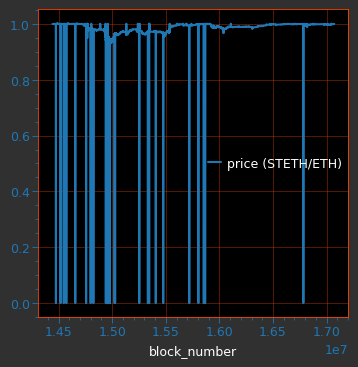

In [22]:
query_swaps.plot(x='block_number', y='price (STETH/ETH)')

<Axes: xlabel='block_number'>

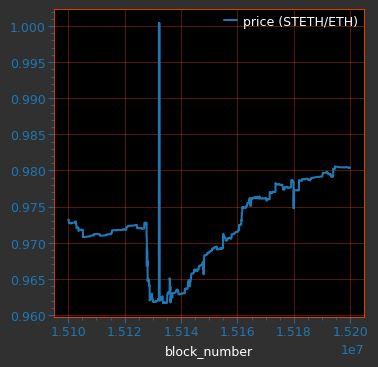

In [23]:
# well those are weird dips and spikes. look at smooth parts
query_swaps[(query_swaps['block_number'] > 15100000) & (query_swaps['block_number'] < 15200000)].plot(x='block_number', y='price (STETH/ETH)')

<Axes: xlabel='block_number'>

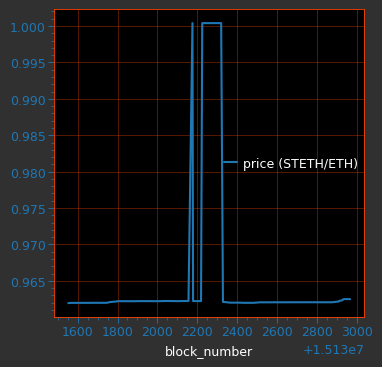

In [24]:
# weird spike for swaps back to 1.000 exchange rate. should look at this in event df
query_swaps[(query_swaps['block_number'] > 15131500) & (query_swaps['block_number'] < 15133000)].plot(x='block_number', y='price (STETH/ETH)')

In [25]:
# first, unfold event arguments into separate columns
def unfold_event_args(key: str, event_args: dict):
    return event_args[key]

for key in query_swaps.iloc[-1]['event_arguments'].keys():
    query_swaps[key] = query_swaps['event_arguments'].apply(lambda ev: unfold_event_args(key, ev))

In [26]:
query_swaps

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,tokens_sold,price (STETH/ETH),buyer,sold_id,bought_id,tokens_bought
0,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xCCF903600486110373734FF0D1aff00aE...,0x2eec7d521e8d30230026474c6f3bdec71b0db772968f...,14443006,0x626961f3b0783e85c5b5ef89416837019419eca40ea4...,535,396,11575093264557493491,0.999642,0xCCF903600486110373734FF0D1aff00aE0A2e231,1,0,11566325797034164639
1,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x22F9dCF4647084d6C31b2765F6910cd85...,0xefa2004889c6b115af4a4b5a956fa934567a877681be...,14443113,0x78a56fe79984b2a50c98da9f2bb64c9f21e0e9fcd213...,148,104,10000000000000000000,0.999641,0x22F9dCF4647084d6C31b2765F6910cd85C178C18,1,0,9992414882825415218
2,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xa10FcA31A2Cb432C9Ac976779DC947CfD...,0xc531cf033a740fb7c93f610f036a36bd31b4383c56b9...,14443210,0x59fbe1f9a7fb4b38b58e7ce7c3b347c18af002025445...,10,0,4556034313377933834,0.999641,0xa10FcA31A2Cb432C9Ac976779DC947CfDb003EF0,1,0,4552576692238558150
3,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xDEF171Fe48CF0115B1d80b88dc8eAB591...,0xcc50b92119fb996f7e82e77b1a37c060109089df294b...,14443215,0x83db11d73db1a2c52a50914b8193bc2e11666a70327d...,183,126,6969454578927918893,0.999640,0xDEF171Fe48CF0115B1d80b88dc8eAB59176FEe57,1,0,6964163189010049639
4,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xfA9a30350048B2BF66865ee20363067c6...,0xe8d01bb953b2161ece86d5104709b6de0e38a562f9ed...,14443228,0xcd13d2ba745ff59eae3ca9a82bcc9adaf17cf324144a...,700,159,133147653402187274232,0.999644,0xfA9a30350048B2BF66865ee20363067c66f67e58,0,1,133141781062011910086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68048,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xFd0000000100069aD1670066004306009...,0x1c5b02717690fc9fc55768fb5a735bc692c07b41a1c5...,17070592,0xc61c54edf9cd11dd769dc3e9044499f5f56d6c21303d...,61,9,9300230333305598541,0.999737,0xFd0000000100069aD1670066004306009B487AD7,1,0,9294068016427801614
68049,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x80d4230c0a68FC59cb264329D3a717FCA...,0x1882d68a85c95c7a1ecd61d93fa1128a8d4d35dc687a...,17070599,0x5430a100f5b80d5b31ceb4bc9646f5b107c7f1dd5afb...,15,1,13092004339731732183,0.999735,0x80d4230c0a68FC59cb264329D3a717FCAa472a13,1,0,13083305414135735981
68050,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xaC6a9e9ca65d4bcbEa3E59c4C40128052...,0x0424c6a5a7053e509d03191e790e9aae69e8a4083315...,17070603,0xaf2e95d4f9fa6628fa73b5356aedf987b5f129cb6a4f...,47,5,6780707999703891968,0.999734,0xaC6a9e9ca65d4bcbEa3E59c4C40128052bcC8882,1,0,6776191471209155972
68051,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x22F9dCF4647084d6C31b2765F6910cd85...,0x66b294e21a5e49b1c04e2a458007e5857037dfb84f3e...,17070704,0x62ef013e31536075c09f5e2f348228d7a4f52f80a35f...,54,9,82028640264765278,0.999733,0x22F9dCF4647084d6C31b2765F6910cd85C178C18,1,0,81973955773304292


In [27]:
# now, check swaps where price spikes up to 1 between blocks 15132100 and 15132400
query_swaps[(query_swaps['block_number'] > 15132100) & (query_swaps['block_number'] < 15132400)]

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,tokens_sold,price (STETH/ETH),buyer,sold_id,bought_id,tokens_bought
20104,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x6A0Af71516690d9e85c579a3a18C76ac8...,0xbaafb0dd80a49933313f5fae987331002fddd66ce398...,15132106,0x3f0dafa8c0bc1f75da4b77185df4b5e72f82367ce714...,6,1,9999999999999999,0.962210,0x6A0Af71516690d9e85c579a3a18C76ac8E33efD1,1,0,9618254969587698
20105,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xfA9a30350048B2BF66865ee20363067c6...,0x38ecea57eecc869cc4a62d96555f15ffe3136f32e06d...,15132124,0x97431fe5b1b89ff7dd6dd8c340ca44707052bbdf729f...,291,123,33697027127765331114,0.962220,0xfA9a30350048B2BF66865ee20363067c66f67e58,0,1,35006090866436268938
20106,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x0031130c56162e00A7e9C01eE4147b11c...,0xed21e5dc1f4099e247b0e815eb3874a7ff1d837d3a8e...,15132156,0x369ef5481d51a5d35c3e5fa176283314cdd284d829eb...,73,46,2461328000000000000,0.962230,0x0031130c56162e00A7e9C01eE4147b11cbac8776,0,1,2556919375120216623
20107,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x6A0Af71516690d9e85c579a3a18C76ac8...,0x7438e5f555766a7f549d93c98022e0c6484729fa8d9f...,15132176,0x7905d8a7692da709cb1f9deaed58d35b3e29fa956fae...,34,10,1,1.000400,0x6A0Af71516690d9e85c579a3a18C76ac8E33efD1,1,0,1
20108,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xfA9a30350048B2BF66865ee20363067c6...,0x722c4b153c4e33f1f5cbd0819d4847851d588d08184a...,15132179,0x8ec15d94c325e9e9552dc7f2c48e20f982ff5e694b3f...,40,24,35006090866436268938,0.962221,0xfA9a30350048B2BF66865ee20363067c66f67e58,1,0,33670122355004768780
20109,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x93Fa84f3102d45fC8e0721143c05b2c15...,0x510b3876226e4bc81ae5afeedc3754dffcd5842bbe1d...,15132219,0x57d3a5987fce344172cc3549db379419aff5745c1ccc...,323,144,1300000000000000000,0.962212,0x93Fa84f3102d45fC8e0721143c05b2c156026025,0,1,1350513053366563254
20110,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x6A0Af71516690d9e85c579a3a18C76ac8...,0x56804547a6d74ac0152564a250aff84cea33b85ed53f...,15132225,0xc766211f83c2421824f805fd98f43bca867a03c63947...,62,8,1,1.000400,0x6A0Af71516690d9e85c579a3a18C76ac8E33efD1,1,0,1
20111,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x6A0Af71516690d9e85c579a3a18C76ac8...,0x3356a73accd1729384e364750411036472c2b9ff5327...,15132229,0x368ab30333621f418f1f6634d737d72adb2f77421518...,58,12,1,1.000400,0x6A0Af71516690d9e85c579a3a18C76ac8E33efD1,1,0,1
20112,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x6A0Af71516690d9e85c579a3a18C76ac8...,0xd6978029b6bb52e8b4ffae55ce8f5a2de8b652ef0a1f...,15132280,0xd3893a3097aadadfa9fea3fadad6f7bdd48c54c03f80...,6,1,1,1.000400,0x6A0Af71516690d9e85c579a3a18C76ac8E33efD1,1,0,1
20113,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x6A0Af71516690d9e85c579a3a18C76ac8...,0x93751a459ccb0838f4cfe07960e6afff4eeaf33facbe...,15132283,0x74c38343de39bd403e4c49b068e389068b21be043ef0...,6,1,1,1.000400,0x6A0Af71516690d9e85c579a3a18C76ac8E33efD1,1,0,1


In [28]:
# ahh, ok :) .. someones selling 1 wei into the pool (see e.g. block 15132225)
# which is causing rounding issues for price calc

<Axes: xlabel='block_number'>

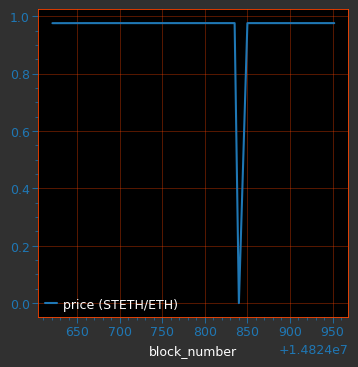

In [29]:
# are the dusting rounding issues also causing those spikes down to zero?
# look at first spike down to 0
query_swaps[(query_swaps['block_number'] > 14824600) & (query_swaps['block_number'] < 14825000)].plot(x='block_number', y='price (STETH/ETH)')

In [30]:
# looks like it (see swap at block 14824840); similar rounding issues except rounded down to zero here
query_swaps[(query_swaps['block_number'] > 14824600) & (query_swaps['block_number'] < 14825000)]

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,tokens_sold,price (STETH/ETH),buyer,sold_id,bought_id,tokens_bought
9181,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x08CC4a936A24A278097FeB566Fccf71FF...,0xbefdc34be9f6d50dcf7d9692c834f2fcb750a7880a30...,14824621,0x10cf6cb3feb597dcaefdfa6fab3730491fea055a51b4...,236,204,2000000000000000000000,0.975627,0x08CC4a936A24A278097FeB566Fccf71FFe84A833,0,1,2049143953945768280377
9182,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x220bdA5c8994804Ac96ebe4DF184d25e5...,0xe7a98e6b9dbdab7e4e169efbb8ba055a9f0a28da8587...,14824663,0xc07d6c8038fd4165fd07386037f0a63b56701b00e1d7...,66,60,9669640333791112375,0.975835,0x220bdA5c8994804Ac96ebe4DF184d25e5c2196D4,0,1,9905129894611176792
9183,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x27239549DD40E1D60F5B80B0C41969237...,0xebbe2cac6a8cea633f4ce13aecc6b3d402f0a53de0df...,14824714,0x090d8bfa4b34ab2e8670c488fdde86fa8c5caef4cbd4...,115,81,4393970000000000000,0.975836,0x27239549DD40E1D60F5B80B0C4196923745B1FD2,1,0,4286080251138498473
9184,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x220bdA5c8994804Ac96ebe4DF184d25e5...,0x6a1a41032f086a90520761d6444937ff73b3aea580c2...,14824787,0x2749b488383fe28bb2abeab7d111d8472e406c445803...,150,92,1000730293446869257,0.975836,0x220bdA5c8994804Ac96ebe4DF184d25e5c2196D4,1,0,976157742840268152
9185,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x22F9dCF4647084d6C31b2765F6910cd85...,0xf97ecc3423d91b6f51e0f384518237b4c5439490f21f...,14824795,0x9038606c713de55bd5e65ed931117811e79820115ee7...,139,77,476594175496263493,0.975836,0x22F9dCF4647084d6C31b2765F6910cd85C178C18,0,1,488200580530122222
9186,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x220bdA5c8994804Ac96ebe4DF184d25e5...,0xd3c3131024e6f4fb640f27a7a07513c44a4247ea663c...,14824820,0x0c7676c94dcc0bd3a33e55f1ae8bce51c723e1251f5d...,43,49,10000000000000000000,0.975835,0x220bdA5c8994804Ac96ebe4DF184d25e5c2196D4,1,0,9754443750619738380
9187,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xEda584Ac4234113e977Bd172e6393F579...,0x953204aa910f21a8012789670728e410039a8f9840b6...,14824835,0xfdf144489b7e75244e22839ce1c8a398f7745a57a1c0...,397,246,47870179539630044007,0.975829,0xEda584Ac4234113e977Bd172e6393F579282b816,1,0,46694419191845003347
9188,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xEda584Ac4234113e977Bd172e6393F579...,0xb2c64c3e9722df4fbcd79662cd6746e069ae08f55242...,14824840,0xfc556897c82ced07979693ce76cd27b4565e78cb0959...,462,195,1,0.000000,0xEda584Ac4234113e977Bd172e6393F579282b816,1,0,0
9189,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x27239549DD40E1D60F5B80B0C41969237...,0xc5de9e64196dff8dd176eece734d88b68e9f4e41cd1d...,14824850,0x1bc4068a1b8284a00ea135dc590d18744bf548a1c795...,84,43,1000000000000000000,0.975824,0x27239549DD40E1D60F5B80B0C4196923745B1FD2,0,1,1024364849804104284
9190,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x11CE580B7D64Fb08F73161AA95835202a...,0xe0c2a35ae160788e8d1d73a5bf465279363581af043f...,14824871,0x0f6bf5cc06980ac2ef46f0a73831494c426c0c9b3336...,394,188,381485996253488127,0.975824,0x11CE580B7D64Fb08F73161AA95835202ae1C9417,1,0,372114382696495947


In [31]:
# apply min size to swaps we care about to ignore the dustings
min_bought = 0.0001 * 1e18  # trade size must be > 0.0001 ETH 
query_swaps = query_swaps[query_swaps['tokens_bought'] > min_bought]

<Axes: xlabel='block_number'>

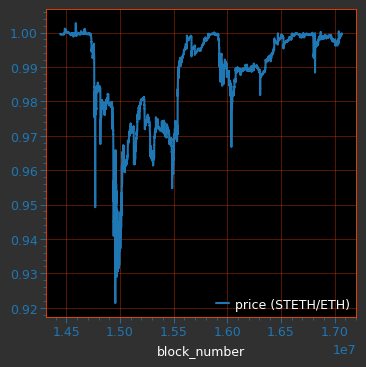

In [32]:
# nice! way better
query_swaps.plot(x='block_number', y='price (STETH/ETH)')

In [33]:
# should smooth the price data out so not so jittery by averaging over 1h for hourly candles.
# keep the volumes numbers as well, so make some slight changes to the (tokens_bought, tokens_sold)
# columns to instead track (volume_coin0, volume_coin1) at each swap

In [34]:
# write a function that returns volume on coin indices for a swap (normalized by 1e18 for decimals)
def get_volume(coin_index: int, x: pd.Series) -> (float, float):
    volume = x['tokens_sold'] if x['sold_id'] == coin_index else x['tokens_bought']
    volume = volume / 1e18
    return volume

In [35]:
%%capture
for coin_index in range(2):
    key = f'volume_coin{coin_index}'
    query_swaps[key] = query_swaps.apply(lambda x: get_volume(coin_index, x), axis=1)

In [36]:
query_swaps

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,tokens_sold,price (STETH/ETH),buyer,sold_id,bought_id,tokens_bought,volume_coin0,volume_coin1
0,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xCCF903600486110373734FF0D1aff00aE...,0x2eec7d521e8d30230026474c6f3bdec71b0db772968f...,14443006,0x626961f3b0783e85c5b5ef89416837019419eca40ea4...,535,396,11575093264557493491,0.999642,0xCCF903600486110373734FF0D1aff00aE0A2e231,1,0,11566325797034164639,11.566326,11.575093
1,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x22F9dCF4647084d6C31b2765F6910cd85...,0xefa2004889c6b115af4a4b5a956fa934567a877681be...,14443113,0x78a56fe79984b2a50c98da9f2bb64c9f21e0e9fcd213...,148,104,10000000000000000000,0.999641,0x22F9dCF4647084d6C31b2765F6910cd85C178C18,1,0,9992414882825415218,9.992415,10.000000
2,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xa10FcA31A2Cb432C9Ac976779DC947CfD...,0xc531cf033a740fb7c93f610f036a36bd31b4383c56b9...,14443210,0x59fbe1f9a7fb4b38b58e7ce7c3b347c18af002025445...,10,0,4556034313377933834,0.999641,0xa10FcA31A2Cb432C9Ac976779DC947CfDb003EF0,1,0,4552576692238558150,4.552577,4.556034
3,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xDEF171Fe48CF0115B1d80b88dc8eAB591...,0xcc50b92119fb996f7e82e77b1a37c060109089df294b...,14443215,0x83db11d73db1a2c52a50914b8193bc2e11666a70327d...,183,126,6969454578927918893,0.999640,0xDEF171Fe48CF0115B1d80b88dc8eAB59176FEe57,1,0,6964163189010049639,6.964163,6.969455
4,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xfA9a30350048B2BF66865ee20363067c6...,0xe8d01bb953b2161ece86d5104709b6de0e38a562f9ed...,14443228,0xcd13d2ba745ff59eae3ca9a82bcc9adaf17cf324144a...,700,159,133147653402187274232,0.999644,0xfA9a30350048B2BF66865ee20363067c66f67e58,0,1,133141781062011910086,133.147653,133.141781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68048,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xFd0000000100069aD1670066004306009...,0x1c5b02717690fc9fc55768fb5a735bc692c07b41a1c5...,17070592,0xc61c54edf9cd11dd769dc3e9044499f5f56d6c21303d...,61,9,9300230333305598541,0.999737,0xFd0000000100069aD1670066004306009B487AD7,1,0,9294068016427801614,9.294068,9.300230
68049,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x80d4230c0a68FC59cb264329D3a717FCA...,0x1882d68a85c95c7a1ecd61d93fa1128a8d4d35dc687a...,17070599,0x5430a100f5b80d5b31ceb4bc9646f5b107c7f1dd5afb...,15,1,13092004339731732183,0.999735,0x80d4230c0a68FC59cb264329D3a717FCAa472a13,1,0,13083305414135735981,13.083305,13.092004
68050,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0xaC6a9e9ca65d4bcbEa3E59c4C40128052...,0x0424c6a5a7053e509d03191e790e9aae69e8a4083315...,17070603,0xaf2e95d4f9fa6628fa73b5356aedf987b5f129cb6a4f...,47,5,6780707999703891968,0.999734,0xaC6a9e9ca65d4bcbEa3E59c4C40128052bcC8882,1,0,6776191471209155972,6.776191,6.780708
68051,TokenExchange,0xDC24316b9AE028F1497c275EB9192a3Ea0f67022,{'buyer': '0x22F9dCF4647084d6C31b2765F6910cd85...,0x66b294e21a5e49b1c04e2a458007e5857037dfb84f3e...,17070704,0x62ef013e31536075c09f5e2f348228d7a4f52f80a35f...,54,9,82028640264765278,0.999733,0x22F9dCF4647084d6C31b2765F6910cd85C178C18,1,0,81973955773304292,0.081974,0.082029


In [37]:
# prep for smoothing by setting index to block number (choose last swap in block to represent price at block)
query_swaps_filtered = query_swaps.filter(['block_number', 'price (STETH/ETH)', 'volume_coin0', 'volume_coin1']).drop_duplicates('block_number', keep='last')
query_swaps_filtered = query_swaps_filtered.set_index('block_number')

In [38]:
# reindex by block number (1 block steps) and ffill price values 
new_index = range(query_swaps_filtered.index.min(), query_swaps_filtered.index.max()+1)
query_swaps_filtered = query_swaps_filtered.reindex(new_index).ffill()

In [39]:
# separate data into windows of 260 blocks (~ 1h)
# remove first (last_block - first_block) % window rows so even candle windows
window = 260
first_index = (query_swaps_filtered.index[-1] - query_swaps_filtered.index[0]) % window
query_swaps_filtered = query_swaps_filtered[first_index:]

In [40]:
# smooth data using mean over 260 blocks for ~ 1h candles
s = (query_swaps_filtered.index.to_series() / window).astype(int)
query_swaps_candled = query_swaps_filtered.groupby(s).agg({'price (STETH/ETH)': ['first', 'max', 'min', 'last', 'mean'], 'volume_coin0': 'sum', 'volume_coin1': 'sum'}).set_index(s.index[::window])
query_swaps_candled

price (STETH/ETH)                                          \
                         first       max       min      last      mean   
block_number                                                             
14443021              0.999642  0.999655  0.999640  0.999655  0.999643   
14443281              0.999655  0.999655  0.999613  0.999613  0.999635   
14443541              0.999613  0.999613  0.999519  0.999519  0.999574   
14443801              0.999519  0.999519  0.999515  0.999515  0.999518   
14444061              0.999515  0.999517  0.999511  0.999515  0.999514   
...                        ...       ...       ...       ...       ...   
17069801              0.999721  0.999737  0.999718  0.999737  0.999720   
17070061              0.999737  0.999742  0.999737  0.999741  0.999742   
17070321              0.999741  0.999741  0.999739  0.999739  0.999739   
17070581              0.999739  0.999739  0.999733  0.999733  0.999734   
17070841              0.999733  0.999733  0.999732  0.999732  0.999733   

              volume_coin0  volume_coin1  
                       sum           sum  
block_number                              
14443021       5593.736082   5595.216507  
14443281      39651.156636  39681.535957  
14443541      29545.192948  29570.517667  
14443801       3685.525821   3688.518576  
14444061       1260.328466   1261.404356  
...                    ...           ...  
17069801       2543.651945   2545.164471  
17070061        778.339899    778.692541  
17070321        690.058089    690.513706  
17070581        820.914902    821.461708  
17070841          4.819383      4.822601  

[10108 rows x 7 columns]

<Axes: xlabel='block_number'>

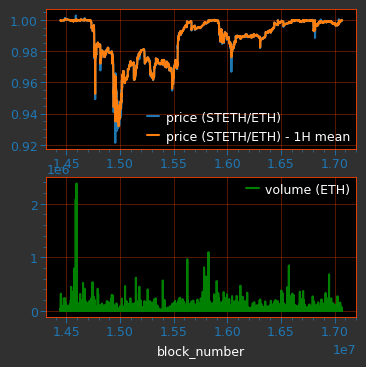

In [41]:
# make some fancy plots w subplots ...
fig, ax = plt.subplots(2, 1)
query_swaps.plot(x='block_number', y='price (STETH/ETH)', ax=ax[0])
query_swaps_candled['price (STETH/ETH)'].plot(y='mean', ax=ax[0], label='price (STETH/ETH) - 1H mean')
query_swaps_candled['volume_coin0'].plot(y='sum', color='g', ax=ax[1], label='volume (ETH)')

In [42]:
# plot the candles since that's dope :o

In [43]:
# get the timestamps every 24 candles (~ 24h) and interpolate the rest (SEE banteg gist again)
# NOTE: include last block in index for interp to work properly
T = 24
blocks = query_swaps_candled.index[::24].to_list() + [query_swaps_candled.index[-1]]

In [44]:
%time timestamps = [ chain.blocks[i].timestamp for i in blocks ]

CPU times: user 2.46 s, sys: 209 ms, total: 2.66 s
Wall time: 19.1 s


In [45]:
query_swaps_candled['timestamp'] = pd.to_datetime(np.interp(query_swaps_candled.index, blocks, timestamps) * 1e9)
query_swaps_candled

price (STETH/ETH)                                          \
                         first       max       min      last      mean   
block_number                                                             
14443021              0.999642  0.999655  0.999640  0.999655  0.999643   
14443281              0.999655  0.999655  0.999613  0.999613  0.999635   
14443541              0.999613  0.999613  0.999519  0.999519  0.999574   
14443801              0.999519  0.999519  0.999515  0.999515  0.999518   
14444061              0.999515  0.999517  0.999511  0.999515  0.999514   
...                        ...       ...       ...       ...       ...   
17069801              0.999721  0.999737  0.999718  0.999737  0.999720   
17070061              0.999737  0.999742  0.999737  0.999741  0.999742   
17070321              0.999741  0.999741  0.999739  0.999739  0.999739   
17070581              0.999739  0.999739  0.999733  0.999733  0.999734   
17070841              0.999733  0.999733  0.999732  0.999732  0.999733   

              volume_coin0  volume_coin1           timestamp  
                       sum           sum                      
block_number                                                  
14443021       5593.736082   5595.216507 2022-03-23 14:12:37  
14443281      39651.156636  39681.535957 2022-03-23 15:11:02  
14443541      29545.192948  29570.517667 2022-03-23 16:09:27  
14443801       3685.525821   3688.518576 2022-03-23 17:07:52  
14444061       1260.328466   1261.404356 2022-03-23 18:06:17  
...                    ...           ...                 ...  
17069801       2543.651945   2545.164471 2023-04-17 23:40:37  
17070061        778.339899    778.692541 2023-04-18 00:33:35  
17070321        690.058089    690.513706 2023-04-18 01:26:27  
17070581        820.914902    821.461708 2023-04-18 02:19:19  
17070841          4.819383      4.822601 2023-04-18 03:12:11  

[10108 rows x 8 columns]

In [46]:
# put data into new df for ohlcv with 1h candles
query_swaps_ohlcv = pd.DataFrame({
    'Open': query_swaps_candled['price (STETH/ETH)']['first'],
    'High': query_swaps_candled['price (STETH/ETH)']['max'],
    'Low': query_swaps_candled['price (STETH/ETH)']['min'],
    'Close': query_swaps_candled['price (STETH/ETH)']['last'],
    'Volume': query_swaps_candled['volume_coin0']['sum'],
    'Date': query_swaps_candled['timestamp']
})
query_swaps_ohlcv = query_swaps_ohlcv.set_index('Date')
query_swaps_ohlcv

,Open,High,Low,Close,Volume
Date,,,,,
2022-03-23 14:12:37,0.999642,0.999655,0.999640,0.999655,5593.736082
2022-03-23 15:11:02,0.999655,0.999655,0.999613,0.999613,39651.156636
2022-03-23 16:09:27,0.999613,0.999613,0.999519,0.999519,29545.192948
2022-03-23 17:07:52,0.999519,0.999519,0.999515,0.999515,3685.525821
2022-03-23 18:06:17,0.999515,0.999517,0.999511,0.999515,1260.328466
...,...,...,...,...,...
2023-04-17 23:40:37,0.999721,0.999737,0.999718,0.999737,2543.651945
2023-04-18 00:33:35,0.999737,0.999742,0.999737,0.999741,778.339899
2023-04-18 01:26:27,0.999741,0.999741,0.999739,0.999739,690.058089


/Users/mihai/.pyenv/versions/3.10.10/envs/ape-stuff/lib/python3.10/site-packages/mplfinance/_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


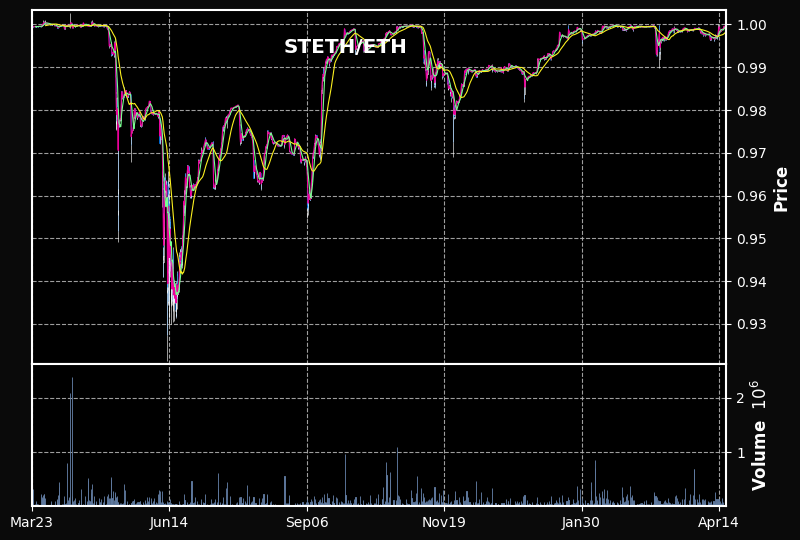

In [47]:
# oooooo fancy :)
def fancy_plot(
    data,
    mav=(10, 50),
    plt_type='candle',
    volume=True,
    datetime_format='%b%d',
    xrotation=0,
    tight_layout=True,
    style='mike', # mpf.available_styles() to pick your fav
    **kwargs
):
    mpf.plot(
        data,
        warn_too_much_data=2500,
        mav=mav,
        type=plt_type,
        volume=volume,
        datetime_format=datetime_format,
        xrotation=xrotation,
        tight_layout=tight_layout,
        style=style,
        **kwargs
    )

title="STETH/ETH"
fancy_plot(query_swaps_ohlcv, mav=(10, 50, 200), title=title)


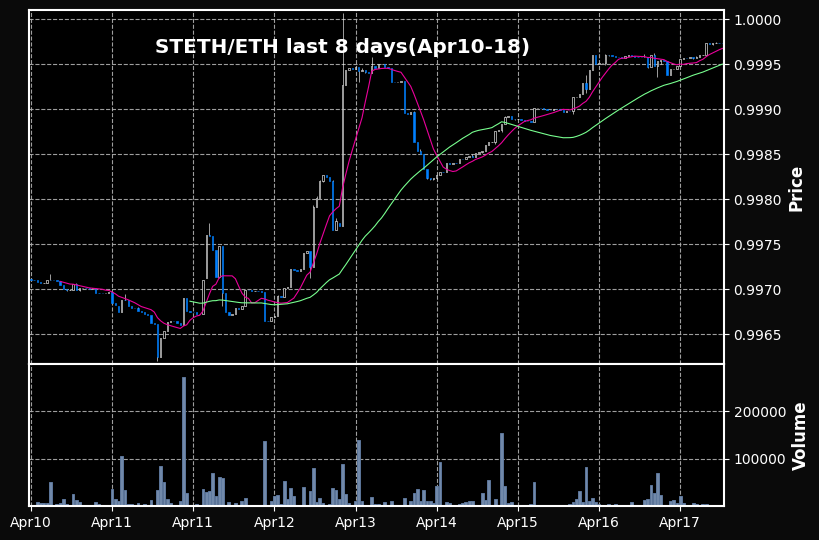

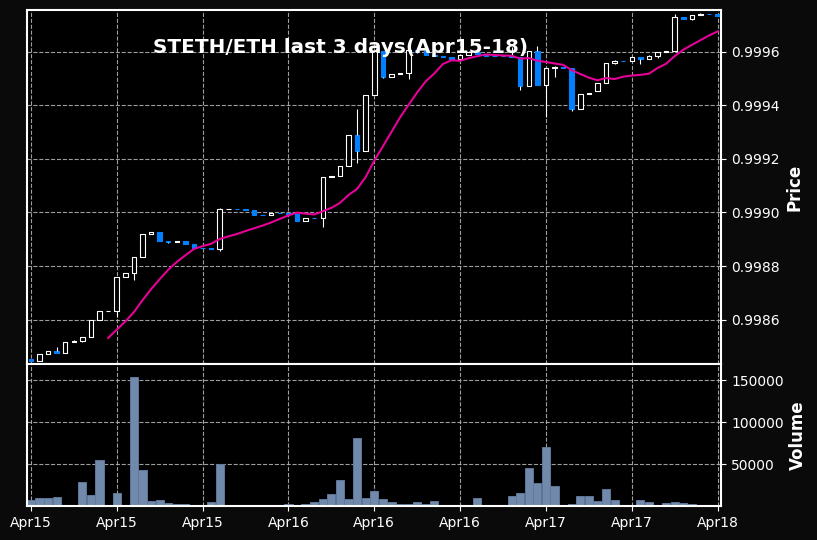

In [48]:
def plot_last_n_days(data, num_days_back=100, **kwargs):
    endPeriod = query_swaps_ohlcv.index[-1]
    startPeriod = endPeriod - pd.Timedelta(days=num_days_back)
    dataToPlot = data.loc[(data.index > startPeriod) & (data.index < endPeriod),:]
    title=f"STETH/ETH last {num_days_back} days"
    title+=f"({startPeriod:%b%d}-{endPeriod:%b%d})" if startPeriod.month != endPeriod.month else f"({startPeriod:%b%d}-{endPeriod:%d})"
    mav = [10]
    if num_days_back > 3:
        mav.append(50)
    if num_days_back > 10:
        mav.append(100)
    fancy_plot(dataToPlot, mav=mav, title=title)

plot_last_n_days(query_swaps_ohlcv, num_days_back=8)
plot_last_n_days(query_swaps_ohlcv, num_days_back=3)
